# 1. Data wrangling and preprocessing

In [207]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

# data augmentation
import imgaug.augmenters as iaa

from sklearn.model_selection import train_test_split

## 1.1. Data loading

Load the satellite images and their corresponding boundary labels into memory.

⚠️ Choose root_path accordingly [set as google drive path, because of colab implementation].  
⚠️ Remember to pair the images and labels appropriately. Here we use a simple sort.

In [208]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [209]:
root_dir = './drive/MyDrive' # '../' on your laptop

In [210]:
# Define paths to training images/labels and test images
train_images_dir = root_dir + '/data/raw/train_images'
train_labels_dir = root_dir + '/data/raw/train_labels'
test_images_dir = root_dir + '/data/raw/test_images'

# Load training images and labels
train_images = []
train_labels = []

# sorting input directory to correctly pair training image/label
for filename in sorted(os.listdir(train_images_dir)):
    if filename.endswith('.png'):
        image = cv2.imread(os.path.join(train_images_dir, filename))
        train_images.append(image)

for filename in sorted(os.listdir(train_labels_dir)):
    if filename.endswith('.png'):
        label = cv2.imread(os.path.join(train_labels_dir, filename), cv2.IMREAD_GRAYSCALE)
        train_labels.append(label)

# Load test images
test_images = []
for filename in sorted(os.listdir(test_images_dir)):
    if filename.endswith('.png'):
        image = cv2.imread(os.path.join(test_images_dir, filename))
        test_images.append(image)

## 1.2. Data Exploration

### 1.2.1 Visualising the data

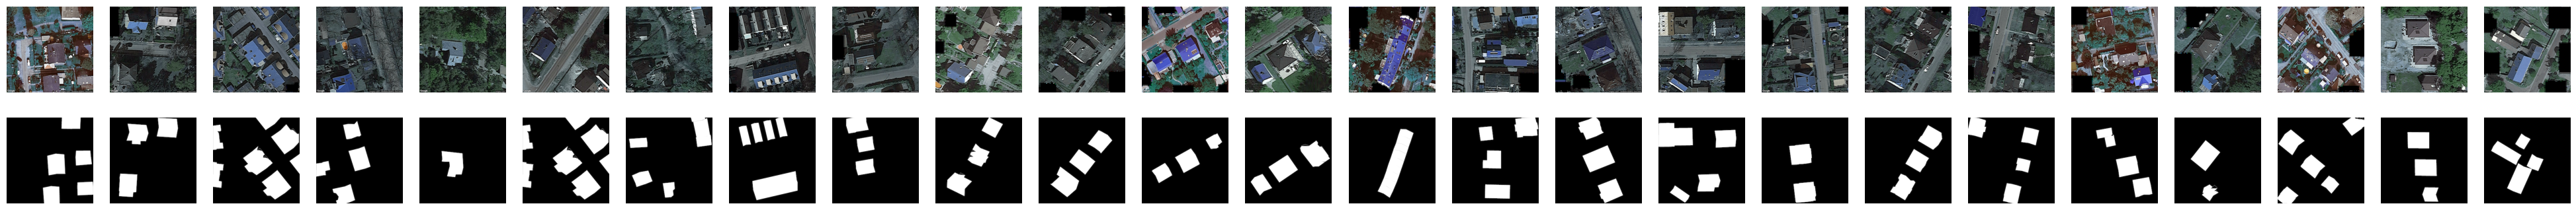

In [211]:
# Diplay training images/labels
fig, ax = plt.subplots(ncols=25, nrows=2, figsize=(50,4))

for idx in range(len(train_images)):

  ax[0, idx].imshow(train_images[idx])
  ax[1, idx].imshow(train_labels[idx], cmap='gray')

  ax[0, idx].axis('off')
  ax[1, idx].axis('off')

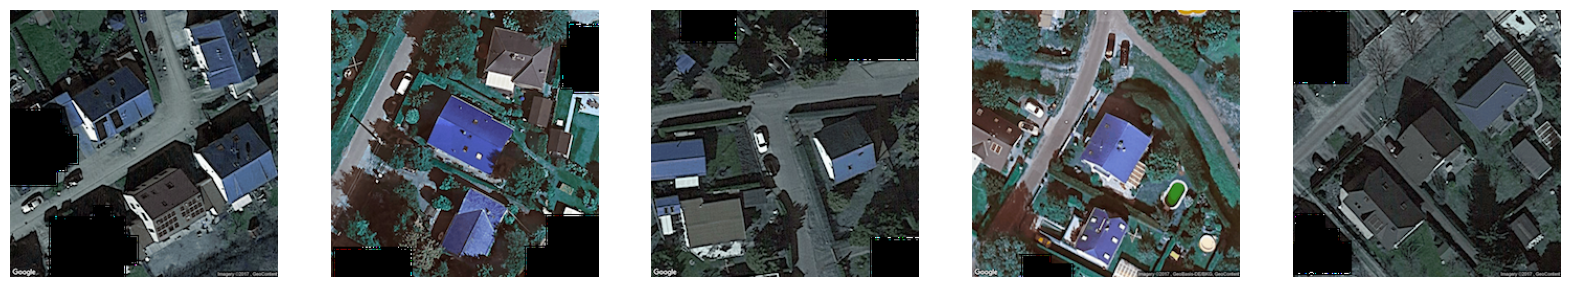

In [212]:
# Display test images
fig, ax = plt.subplots(ncols=5, figsize=(20,4))

for idx in range(len(test_images)):

  ax[idx].imshow(test_images[idx])
  ax[idx].axis('off')

The visualisation confirms that the images/labels have been correctly paired.

🚨 But it also shows that some images have black-spots [might indicate corruption].

**Examples of Corrupted images**

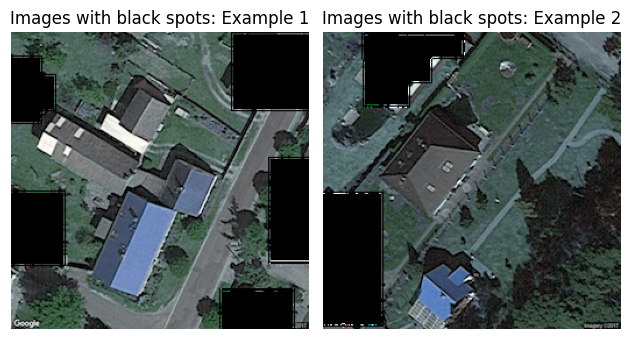

In [213]:
# Training image
plt.subplot(1, 2, 1)
plt.imshow(train_images[-1])
plt.title('Images with black spots: Example 1')
plt.axis('off')

# Training label
plt.subplot(1, 2, 2)
plt.imshow(train_images[-4])
plt.title('Images with black spots: Example 2')
plt.axis('off')

plt.tight_layout()
plt.show()


### 1.2.2. Data distribution

Examine the distribution of the roof boundary masks in the training set. We count the number of positive and negative samples to ensure a balanced dataset.

In [214]:
# Count the average number of positive and negative samples in the boundary
# masks across all the labels in the training set
def count_samples(masks):

    num_positive = np.average([np.sum(masks[idx] > 0) for idx in range(len(masks))])
    num_negative = np.average([np.sum(masks[idx] == 0) for idx in range(len(masks))])
    return num_positive, num_negative

# Call the count_samples function with your boundary masks
num_positive_samples, num_negative_samples = count_samples(train_labels)
print('Averaged across training set:')
print("Positive samples: ", num_positive_samples)
print("Negative samples: ", num_negative_samples)

Averaged across training set:
Positive samples:  10890.24
Negative samples:  54645.76


The numbers of positive samples roughly number 1:5 for every negative cell. This is an imbalanced set, but is not a case of extreme imbalance. We put a warning here to look into this later and move on. ⚠️

## 1.3. Data Preprocessing

### 1.3.1. Resizing images to a consistent resolution

This step is not necessary. All our images are already in a (256 x 256) shape.

In [215]:
# Run this code to ensure that all images are (256x256)
'''
for index in range(len(train_images)):

    # Get the resolution of the image
    height, width, channels = train_images[index].shape

    print(f"Image Resolution: {width}x{height}. Numer of Channels: {channels}")

for index in range(len(train_labels)):

    # Get the resolution of the image
    height, width = train_labels[index].shape

    print(f"Image Resolution: {width}x{height}.")

for index in range(len(test_images)):

    # Get the resolution of the image
    height, width, channels = test_images[index].shape

    print(f"Image Resolution: {width}x{height}. Numer of Channels: {channels}")
'''

# Otherwise, use following code to resize to (256x256)

'''
# Resize images to a consistent resolution
target_resolution = (256, 256)  # Adjust to desired resolution

def resize_image(image, resolution):
    return cv2.resize(image, resolution)

train_images = [resize_image(image, target_resolution) for image in train_images]
train_labels = [resize_image(label, target_resolution) for label in train_labels]
test_images = [resize_image(image, target_resolution) for image in test_images]
'''

'\n# Resize images to a consistent resolution\ntarget_resolution = (256, 256)  # Adjust to desired resolution\n\ndef resize_image(image, resolution):\n    return cv2.resize(image, resolution)\n\ntrain_images = [resize_image(image, target_resolution) for image in train_images]\ntrain_labels = [resize_image(label, target_resolution) for label in train_labels]\ntest_images = [resize_image(image, target_resolution) for image in test_images]\n'

### 1.3.2. Normalise Pixel values

In [216]:
# Normalize pixel values
train_images = np.array(train_images) / 255.0
train_labels = np.array(train_labels) / 255.0
test_images = np.array(test_images) / 255.0

### 1.3.3. Data augmentation

This step is important since we have only 25 training samples. This will increase the training size and improve generalisation. The augmentation techniques we use here are:
* Flip horizontally with a 50% chance
* Rotate image by -20 to 20 degrees
* Scale image by 0.8 to 1.2
* Translate image by -20% to 20% on each axis
* Shear image by -20 to 20 degrees
* Zoom image by 0.8 to 1.2 on each axis

🚨WARNING: Make sure to apply the augmentation identically to the image and the segmentation map.

For every image/segmentation map pair, we make 5 additional data augmented versions.

In [217]:
# Apply techniques like rotation, flipping, scaling, etc. to increase training data size
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

augmenter = iaa.Sequential([
    iaa.Fliplr(0.5),  # Flip horizontally with a 50% chance
    iaa.Affine(rotate=(-20, 20)),  # Rotate image by -20 to 20 degrees
    iaa.Affine(scale=(0.8, 1.2)),  # Scale image by 0.8 to 1.2
    iaa.Affine(translate_percent=(-0.2, 0.2)),  # Translate image by -20% to 20% on each axis
    iaa.Affine(shear=(-20, 20)),  # Shear image by -20 to 20 degrees
    iaa.Affine(scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}),  # Zoom image by 0.8 to 1.2 on each axis
])

# Apply transformations identically to image and map
# Make 5 augmentations for each image/map pair

augmented_train_images = []
augmented_train_labels = []

for idx in range(len(train_images)):
    image = train_images[idx]
    segmap = SegmentationMapsOnImage(train_labels[idx], shape=train_labels[idx].shape)

    for _ in range(5):
        images_aug_i, segmaps_aug_i = augmenter(image=image, segmentation_maps=segmap)
        augmented_train_images.append(images_aug_i)
        augmented_train_labels.append(segmaps_aug_i.arr)

# Combine with original dataset of 25 images
train_images = np.concatenate([train_images, augmented_train_images])
train_labels = np.concatenate([train_labels, np.squeeze(augmented_train_labels)])

/usr/local/lib/python3.10/dist-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


How big have we made our training set? 150
Some examples:


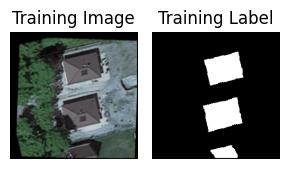

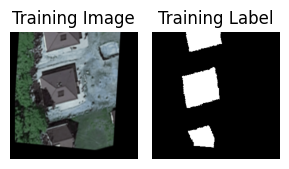

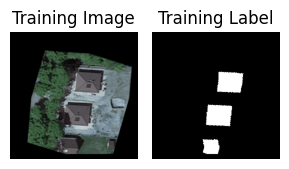

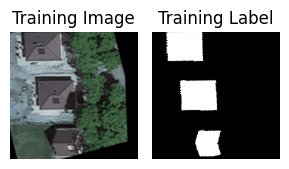

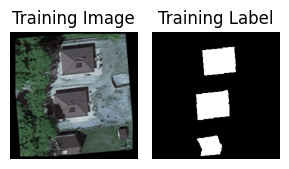

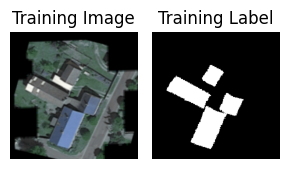

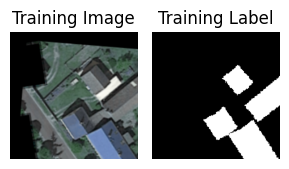

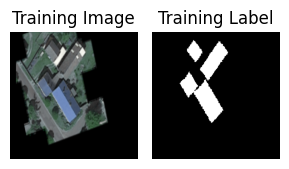

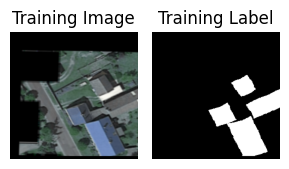

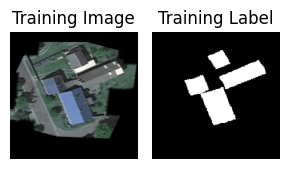

In [218]:
print(f"How big have we made our training set? {len(train_images)}")
print("Some examples:")

# Display some random examples from the augmented set, to ensure
# augmentation has been performed, and that it has been performed
# identically to image/map pair
for index in range(len(augmented_train_images))[-10:]:

    plt.figure(figsize=(3,2))
    # Training image
    plt.subplot(1, 2, 1)
    plt.imshow(augmented_train_images[index])
    plt.title('Training Image')
    plt.axis('off')

    # Training label
    plt.subplot(1, 2, 2)
    plt.imshow(augmented_train_labels[index], cmap='gray')
    plt.title('Training Label')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

## 1.4. Train-validation split

We make a 70-30 split between our training and validation sets.

⚠️ We decreased this from 80-20, because the validation set was too small for a reasonable prediction.

⚠️ The validation set thus defined is used for the model evaluation. This is an important point to keep in mind, because, the U-Net model we use below has, as one of its options, `validation_split`, which is the portion of the training data that would be used for the validation of the training. The `(val_images, val_labels)` we set aside for model evaluation.

In [219]:
# Split training data into training and validation subsets
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.3, random_state=42)

**Save (re-scaled) preprocessed data**

The rescaling is needed to save the data. See reason [here](https://stackoverflow.com/a/54165573).

In [220]:
# Save preprocessed training images and labels
train_output_dir = root_dir + '/data/preprocessed/train'
os.makedirs(train_output_dir, exist_ok=True)

for i, image in enumerate(train_images):
    image_filename = f"rescaled_preprocessed_image_{i}.jpg"
    cv2.imwrite(os.path.join(train_output_dir, image_filename), 255*image)

for i, label in enumerate(train_labels):
    label_filename = f"rescaled_preprocessed_label_{i}.png"
    cv2.imwrite(os.path.join(train_output_dir, label_filename), 255*label)

# Save preprocessed validation images and labels
val_output_dir = root_dir + '/data/preprocessed/valid'
os.makedirs(val_output_dir, exist_ok=True)

for i, image in enumerate(val_images):
    image_filename = f"rescaled_preprocessed_image_{i}.jpg"
    cv2.imwrite(os.path.join(val_output_dir, image_filename), 255*image)

for i, label in enumerate(val_labels):
    label_filename = f"rescaled_preprocessed_label_{i}.png"
    cv2.imwrite(os.path.join(val_output_dir, label_filename), 255*label)

# Save preprocessed test images
test_output_dir = root_dir + '/data/preprocessed/test'
os.makedirs(test_output_dir, exist_ok=True)

for i, image in enumerate(test_images):
    image_filename = f"rescaled_preprocessed_image_{i}.jpg"
    cv2.imwrite(os.path.join(test_output_dir, image_filename), 255*image)
